# Exercise 11: Fit — Exponential background + Gaussian signal

In this notebook, we practice fitting experimental-like data using simple models.

**Main goals:**
1. Load and visualize unlabeled data as a histogram.
2. Build simple models for **background** (exponential) and **signal** (Gaussian).
3. Perform a **pre-fit** of the background using sideband data (x = 0–5).
4. Run a **combined fit** (signal + background) with curve fitting.
5. Plot and compare:
   - background component
   - signal component
   - combined fit vs. data

The aim is to understand how we can **separate signal from background** using basic fitting techniques and evaluate the quality of the fit.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# --- 1. Load unlabeled CSV (generated previously as sample_lec11.csv) ---
df = pd.read_csv("data/sample_ex11.csv")
x = df["x"].values
print("Loaded:", df.shape, "rows")

Loaded: (52000, 1) rows


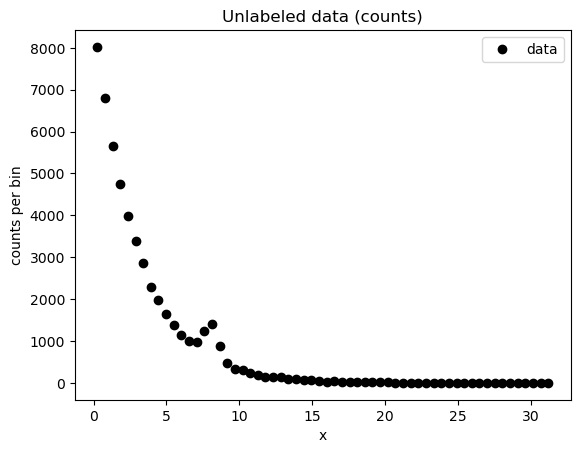

In [4]:
# --- 2. Build histogram (counts) with fixed bins ---
bins = 60
counts, edges = np.histogram(x, bins=bins)
centers = 0.5 * (edges[1:] + edges[:-1])

# Visualize data
plt.figure()
plt.plot(centers, counts, "ko", label="data")
plt.xlabel("x")
plt.ylabel("counts per bin")
plt.title("Unlabeled data (counts)")
plt.legend(); plt.show()


In [5]:
# --- 3. Define models ---
def gauss(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def expo(x, B, tau):
    return B * np.exp(-x / tau)

def model(x, B, tau, A, mu, sigma):
    return expo(x, B, tau) + gauss(x, A, mu, sigma)


In [7]:
# --- 4. Pre-fit (Background Only) ---
# Background Only 
mask = (centers >= 0) & (centers <= 5) & (counts > 0)
x_sb = centers[mask]
y_sb = counts[mask]

p0 = [y_sb.max(), np.mean(x_sb)]
popt, pcov = curve_fit(expo, x_sb, y_sb, p0=p0)
B_fit, tau_fit = popt
print(f"Prefit background: B={B_fit:.2f}, tau={tau_fit:.2f}")


Prefit background: B=8784.27, tau=2.99


In [8]:
# --- 5. Combined Fit ---
p0 = [B_fit, tau_fit, 500, 8, 2]  # [B, tau, A, mu, sigma]

# Poisson uncertainties for weighted fit
sigma_y = np.sqrt(np.maximum(counts, 1.0))

pars, cov = curve_fit(model, centers, counts, p0=p0, sigma=sigma_y, absolute_sigma=True)
B, tau, A, mu, sigma = pars

print("Fit results:")
print(f"B={B:.1f}, tau={tau:.2f}, A={A:.1f}, mu={mu:.2f}, sigma={sigma:.2f}")


Fit results:
B=8807.0, tau=2.98, A=837.8, mu=8.04, sigma=0.51


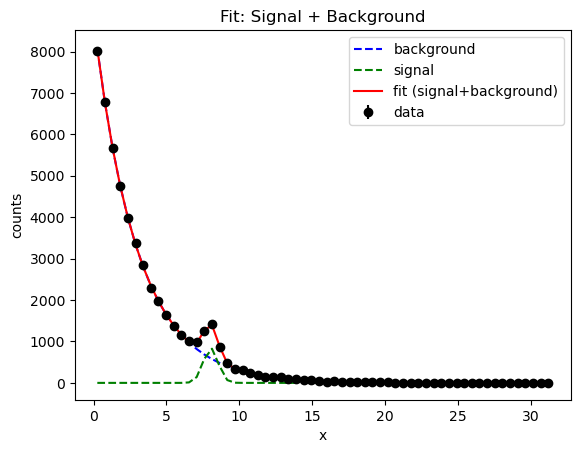

In [9]:
# --- 6. Plot components ---

plt.errorbar(centers, counts, yerr=sigma_y, fmt="ko", label="data")

# individual components
plt.plot(centers, expo(centers, B, tau), "b--", label="background")
plt.plot(centers, gauss(centers, A, mu, sigma), "g--", label="signal")

# combined model
plt.plot(centers, model(centers, *pars), "r-", label="fit (signal+background)")

plt.xlabel("x")
plt.ylabel("counts")
plt.title("Fit: Signal + Background")
plt.legend()
plt.show()
